## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from collections import Counter
from scipy.signal import find_peaks

from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

pd.set_option('display.max_colwidth', None)

## PREPROCESSING

In [2]:
def clean_promed(file_path):
    """
    This function preprocesses the promed data from a text file to a df

    Args:
    file_path (str): location of the promed raw data file

    Returns:
    df: a dataframe containing all the promed data
    """
    with open(file_path) as f:
        data = f.readlines()

    # Extract the fourth field from each line, and then extract the text before the first comma
    text_items = [re.search(r'^([^,]+)', line.split('\t')[3]).group(1).strip() for line in data]

    # Count the frequency of each text item
    freq_counts = Counter(text_items)

    # Create a dataframe with two columns: number and disease
    df = pd.DataFrame(freq_counts.most_common(), columns=["disease", "number"])

    # Iterate over the disease column and remove the text before the rightmost '>' and the space after it
    df['disease'] = df['disease'].apply(lambda x: x.split('>')[-1].strip())
    
    # Extract the required information from each line and save it in a list of dictionaries
    records = []
    for line in data:
        fields = line.split('\t')
        id1, id2, date_id = fields[:3]
        subject = re.search(r'^([^,]+)', fields[3]).group(1).strip()
        subject = subject.split('>')[-1].strip()
        records.append({"id1": id1, "id2": id2, "date.id": date_id, "subject": subject})

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(records)

    # Split the "date.id" column into "date" and "id_part" columns
    df[['date', 'id_part']] = df['date.id'].str.split('.', n=1, expand=True)

    # Convert the "date" column to a datetime object, handling errors by replacing with NaN
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')

    # Replace any rows with invalid dates with NaN
    df.loc[df['date'].isna(), ['date', 'id_part']] = pd.NaT

    # Convert the "date" column back to a string in the desired format
    df['date'] = df['date'].dt.strftime('%Y/%m/%d')
    
    return df

def map_df(disease_names, df, subject_column):
    """
    This function maps disease names to corresponding filtered DataFrames.

    Args:
    disease_names (list): List of disease names to be mapped.
    df (pd.DataFrame): The DataFrame containing the data.
    subject_column (str): The name of the column containing the disease subject information.

    Returns:
    dict: A dictionary where keys are disease names and values are filtered DataFrames.
    """
    df_mapping = {}
    
    for disease in disease_names:
        filtered_df = df[df[subject_column].notna() & df[subject_column].str.contains(disease, case=False)].copy()
        df_mapping[disease] = filtered_df
        print(f"{disease} dataframe has {len(filtered_df)} rows")
        
    print("\n")
    
    return df_mapping

def clean_deltas(file_path):
    """
    This function preprocesses the deltas data from a text file to a df

    Args:
    file_path (str): location of the deltas raw data file

    Returns:
    df: a dataframe containing all the deltas data
    """
    
    # Define the column names for the WHO DataFrame
    col_names = ["Difference in Days", "col2", "cosine", "col4", "who_link", "promed_link"]

    # Read in data from "deltas"
    deltas_data = pd.read_csv(file_path, sep="\t", header=None, names=col_names)
    
    deltas_data['id_extracted'] = deltas_data['promed_link'].str.extract(r'(\d+\.\d+)')
    
    return deltas_data

def merge_who_deltas(promed_df, deltas_data):
    # merge 2 df's to get WHO data correlated with subject as determined earlier 
    # we know that the WHO and PROMED link columns are associated already in the deltas data set
    merged_df = promed_df.merge(deltas_data, left_on='date.id', right_on='id_extracted', how='inner')

    # top diseases in promed links as mentioned above
    disease_names = ['Avian influenza', 'Cholera', 'Anthrax', 'Salmonellosis', 'Rabies', 
                     'Foot & mouth disease', 'Hand', 'West Nile virus', 'Meningitis', 
                     'Undiagnosed deaths', 'Plague', 'Chronic wasting disease', 
                     'Undiagnosed die-off', 'Brucellosis', 'E. coli O157', 'Undiagnosed disease']
    
    # add new column for the top 20
    merged_df['subject_keyword'] = merged_df['subject'].apply(lambda x: next((disease for disease in disease_names if disease in x), 'other'))

    # clean up a little bit
    merged_df = merged_df.drop(columns=['id1', 'id2', 'date.id', 'id_part', 'col2', 'col4'])

    return merged_df


In [3]:
def preprocess(promed_file_path, deltas_file_path, disease_names):
    promed_df = clean_promed(promed_file_path)
    deltas_df = clean_deltas(deltas_file_path) #this indirectly gets us the WHO data 
    
    df_mapping_promed = map_df(disease_names, promed_df, 'subject')
    
    merged_df = merge_who_deltas(promed_df, deltas_df)
    df_mapping_who = map_df(disease_names, merged_df, 'subject_keyword')
    
    return df_mapping_promed, df_mapping_who

## ANALYSIS

In [4]:
# Define a function to find the top 5 peaks sorted by date
def find_top_peaks(df, column_name):
    df_sorted = df.sort_values(by=column_name, ascending=False).head(5)
    return df_sorted.sort_values(by='date')

# Create a function to generate summaries using LangChain
def generate_summary(llm, disease, monthly_counts, weekly_counts_filtered, top_monthly_peaks, top_weekly_peaks_filtered):
    prompt_template = PromptTemplate(
        input_variables=["disease", "monthly_counts", "weekly_counts_filtered", "top_monthly_peaks", "top_weekly_peaks_filtered"],
        template="""
        Provide a summary for the disease: {disease}. 
        Monthly counts: {monthly_counts}.
        Weekly counts (2007-2010): {weekly_counts_filtered}.
        Top 5 monthly peaks: {top_monthly_peaks}.
        Top 5 weekly peaks (2007-2010): {top_weekly_peaks_filtered}.
        """
    )
    
    chain = LLMChain(llm=llm, prompt=prompt_template)
    summary = chain.run(disease=disease, monthly_counts=monthly_counts.to_dict(), weekly_counts_filtered=weekly_counts_filtered.to_dict(), top_monthly_peaks=top_monthly_peaks.to_dict(), top_weekly_peaks_filtered=top_weekly_peaks_filtered.to_dict())
    return summary

def process_disease_data(input_dict, id_column, label):
    """
    Process the disease data and find the top 5 peaks for monthly and weekly counts.

    Args:
    disease_dfs (dict): Dictionary where keys are disease names and values are corresponding DataFrames.
    id_column (str): The column name to use for counting records.
    label (str): Label to use for the source (e.g., "Promed" or "WHO").

    Returns:
    dict: Dictionary containing the peak data for each disease.
    """
    peak_data = {}

    for disease, disease_df in input_dict.items():
        # Convert the 'date' column to a datetime object
        disease_df['date'] = pd.to_datetime(disease_df['date'])
        disease_df.set_index('date', inplace=True)
        
        # Resample the data to a monthly frequency
        monthly_counts = disease_df.resample('M').count()
        monthly_counts = monthly_counts[[id_column]].rename(columns={id_column: 'count'})
        monthly_counts.reset_index(inplace=True)
        
        # Resample the data to a weekly frequency
        weekly_counts = disease_df.resample('W').count()
        weekly_counts = weekly_counts[[id_column]].rename(columns={id_column: 'count'})
        weekly_counts.reset_index(inplace=True)
        
        # Filter weekly counts for the specified time range
        weekly_counts_filtered = weekly_counts[(weekly_counts['date'] >= '2007-01-01') & (weekly_counts['date'] <= '2010-12-31')]
        
        # Find the top 5 peaks for monthly and weekly counts
        top_monthly_peaks = find_top_peaks(monthly_counts, 'count')
        top_weekly_peaks_filtered = find_top_peaks(weekly_counts_filtered, 'count')
        
        # Store the peak data in the dictionary
        if disease not in peak_data:
            peak_data[disease] = {}
        peak_data[disease][label] = {
            "Monthly": top_monthly_peaks,
            "Weekly (2007-2010)": top_weekly_peaks_filtered
        }
    
    return peak_data

# Plotting functions
def plot_counts(df, column_name, title, peaks=None):
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df[column_name])
    if peaks is not None:
        plt.scatter(peaks['date'], peaks[column_name], color='r', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title(title)
    plt.grid(True)
    plt.show()

def analyze(llm, promed_dict, who_dict, ):
    # Process Promed data
    peak_data_promed = process_disease_data(promed_dict, 'id1', 'Promed')

    # Process WHO data
    peak_data_who = process_disease_data(who_dict, 'who_link', 'WHO')

    # Merge the peak data
    for disease in peak_data_promed:
        if disease in peak_data_who:
            peak_data_promed[disease].update(peak_data_who[disease])

    peak_data = peak_data_promed

    # Generate and print the summary using LangChain
    for disease, data in peak_data.items():
        summary = generate_summary(llm, disease, data['Promed']['Monthly'], data['Promed']['Weekly (2007-2010)'], data['WHO']['Monthly'], data['WHO']['Weekly (2007-2010)'])
        print(f"Summary for {disease}:\n{summary}\n")
        
    return peak_data

## MAIN

In [5]:
def main():
    
    promed_file_path = "./promed/summaries/ids"
    deltas_file_path = "./deltas"
    disease_names = ['Avian influenza', 'Cholera', 'Anthrax', 'Salmonellosis', 'Rabies', 'Meningitis', 'Plague', 'West Nile virus']
    
    promed, who = preprocess(promed_file_path, deltas_file_path, disease_names) 
    
    llm = OpenAI(api_key="")

    results = analyze(llm, promed, who)
    
    return results

In [6]:
data_dict = main()

Avian influenza dataframe has 5103 rows
Cholera dataframe has 1516 rows
Anthrax dataframe has 2590 rows
Salmonellosis dataframe has 1217 rows
Rabies dataframe has 2114 rows
Meningitis dataframe has 516 rows
Plague dataframe has 616 rows
West Nile virus dataframe has 1286 rows


Avian influenza dataframe has 1915 rows
Cholera dataframe has 420 rows
Anthrax dataframe has 0 rows
Salmonellosis dataframe has 5 rows
Rabies dataframe has 2 rows
Meningitis dataframe has 72 rows
Plague dataframe has 45 rows
West Nile virus dataframe has 25 rows




/usr/local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/usr/local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Summary for Avian influenza:

Avian influenza is a viral disease that primarily affects birds, but can also infect humans and other animals. The disease is caused by various strains of influenza virus, which can lead to mild to severe respiratory illness in birds and potentially serious illness or death in humans. The disease is most common in poultry and wild birds, and can be transmitted to humans through contact with infected birds or their droppings, as well as through close contact with infected humans. The disease has been a concern for public health due to its potential to cause pandemics, and has been periodically monitored and tracked by health organizations.

The monthly counts for avian influenza show a fluctuating pattern, with the highest numbers of cases occurring in the months of October, November, January, February, and April. This could be due to the seasonal nature of the disease, as well as increased surveillance and reporting during these months. The weekly counts f

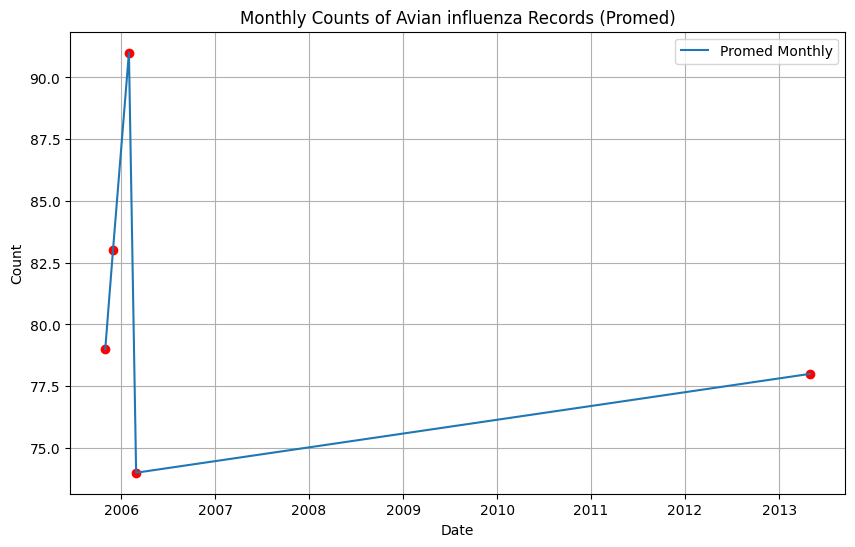

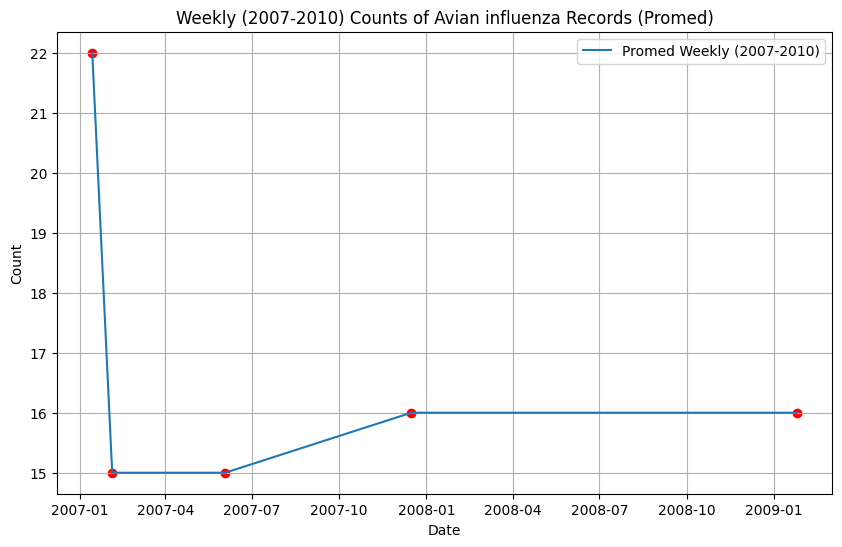

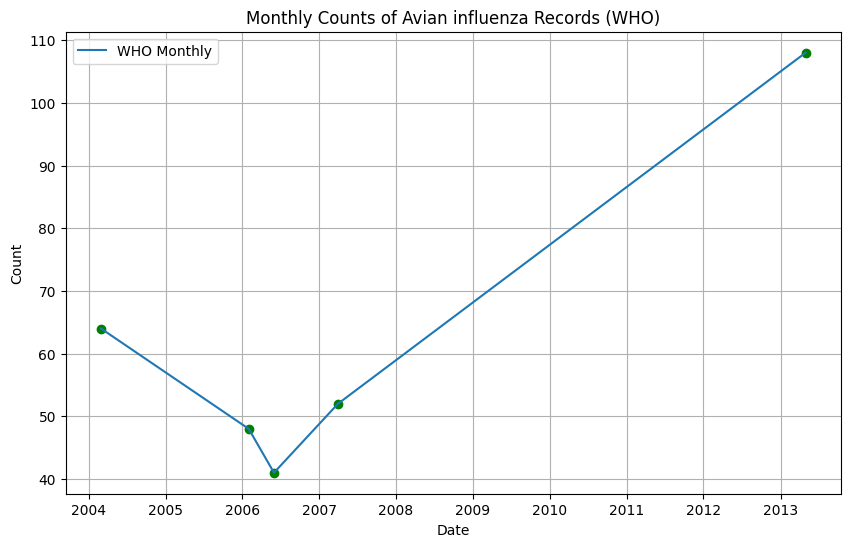

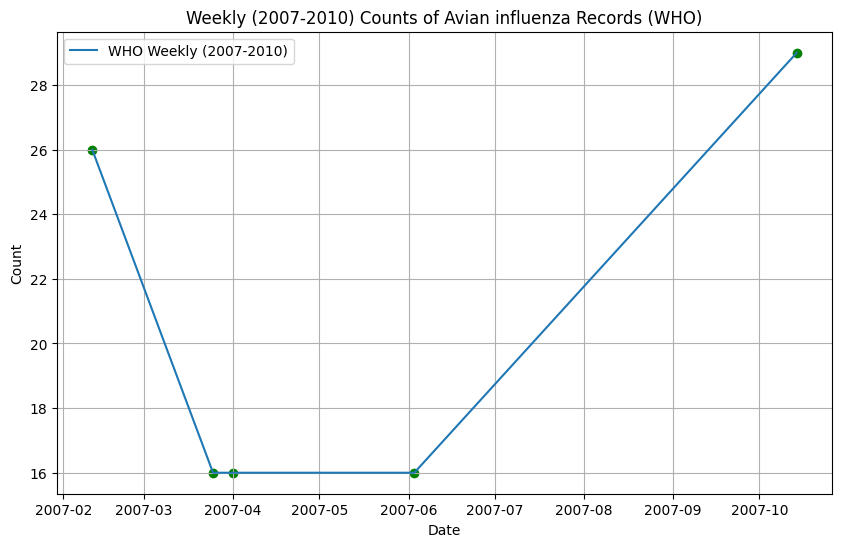

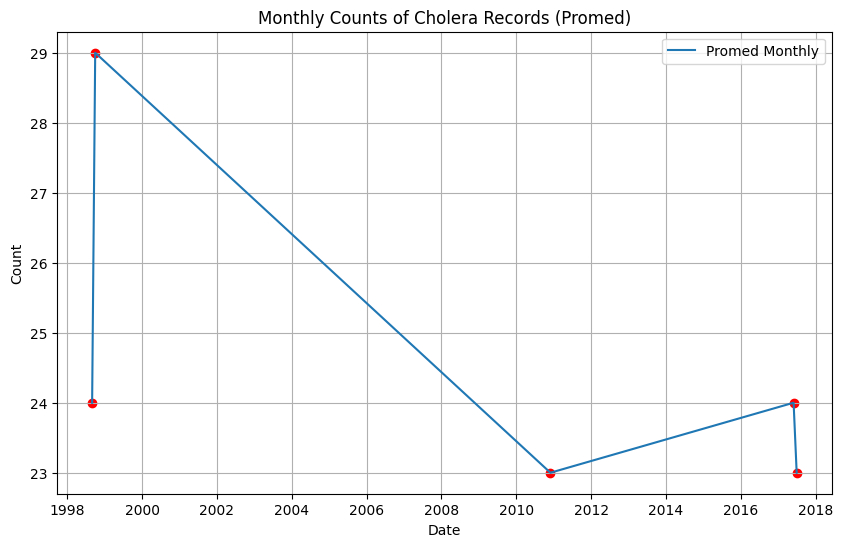

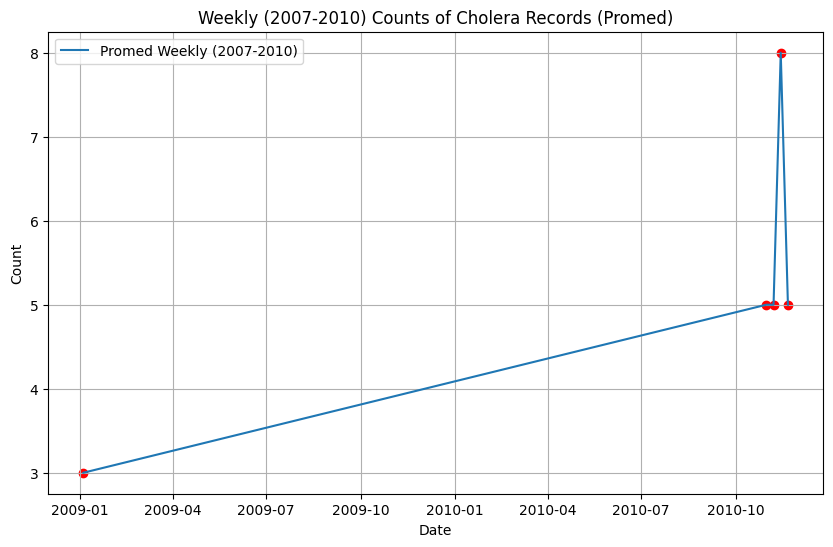

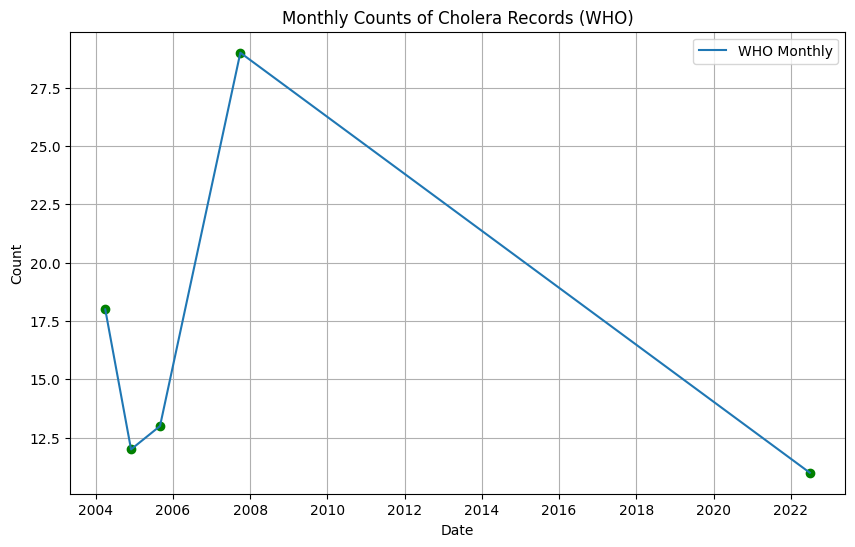

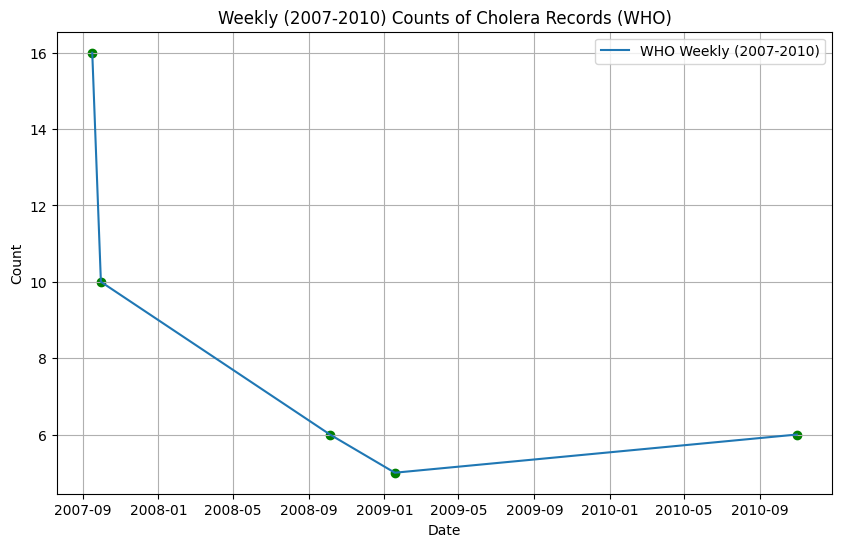

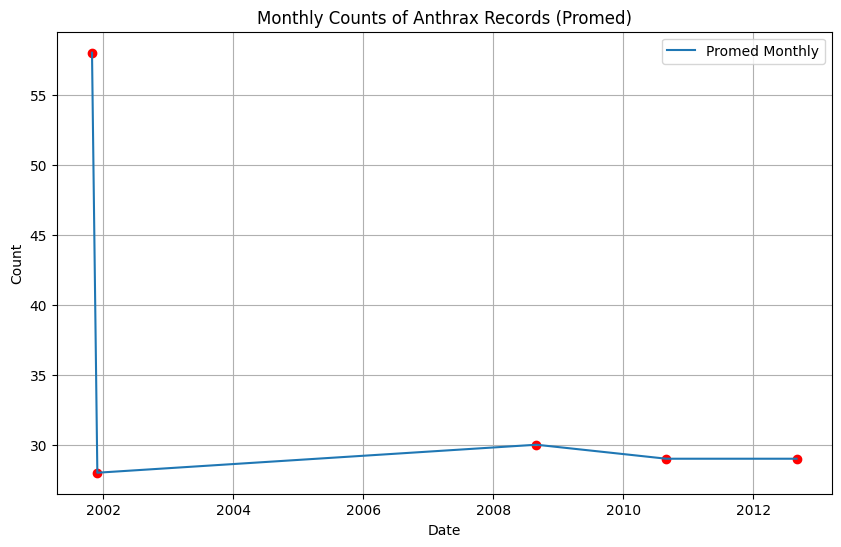

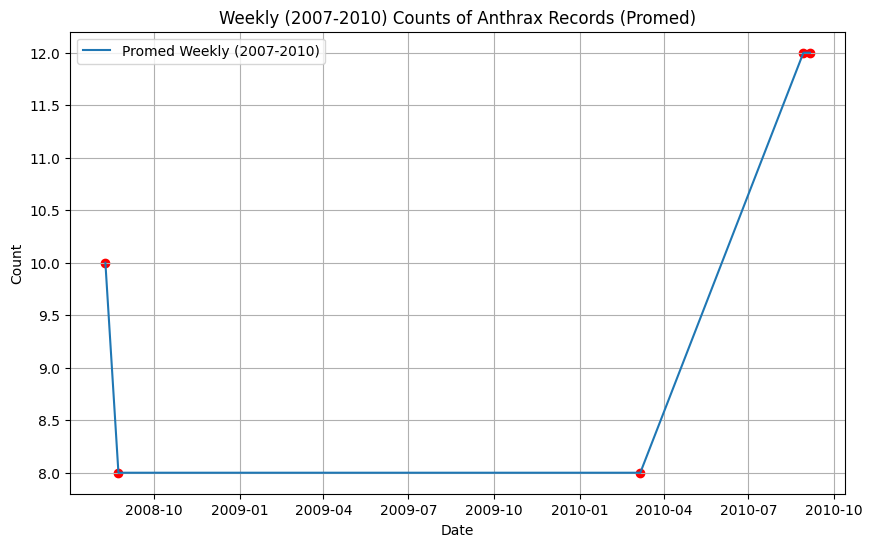

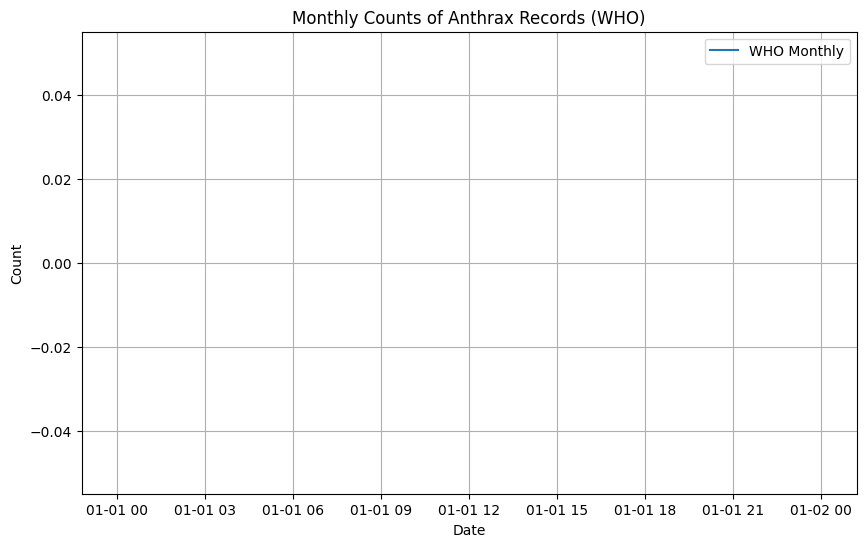

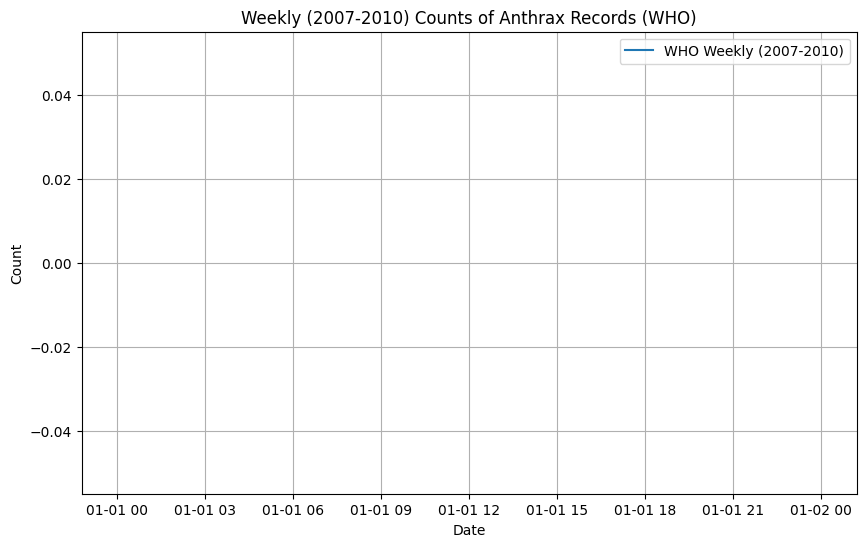

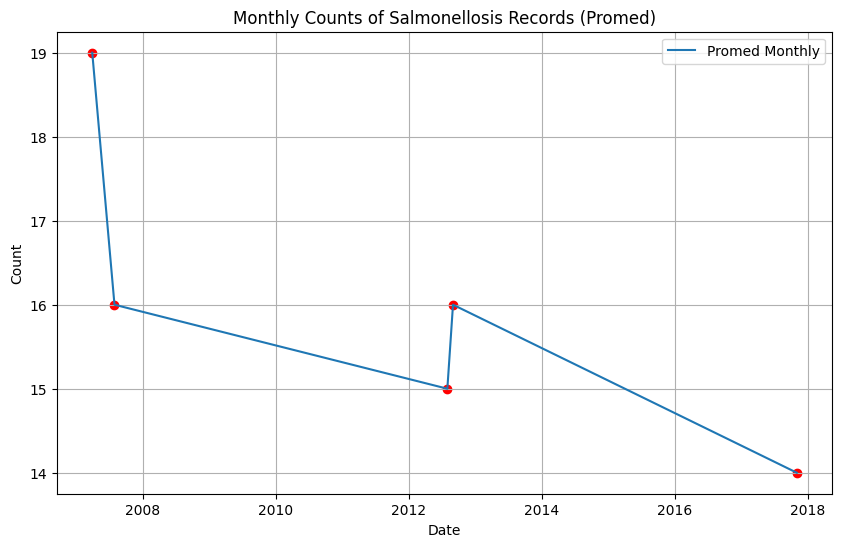

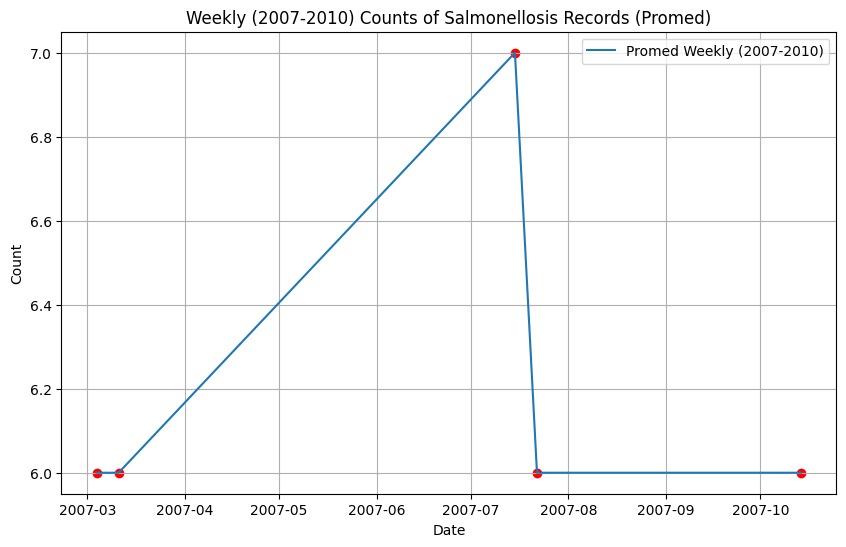

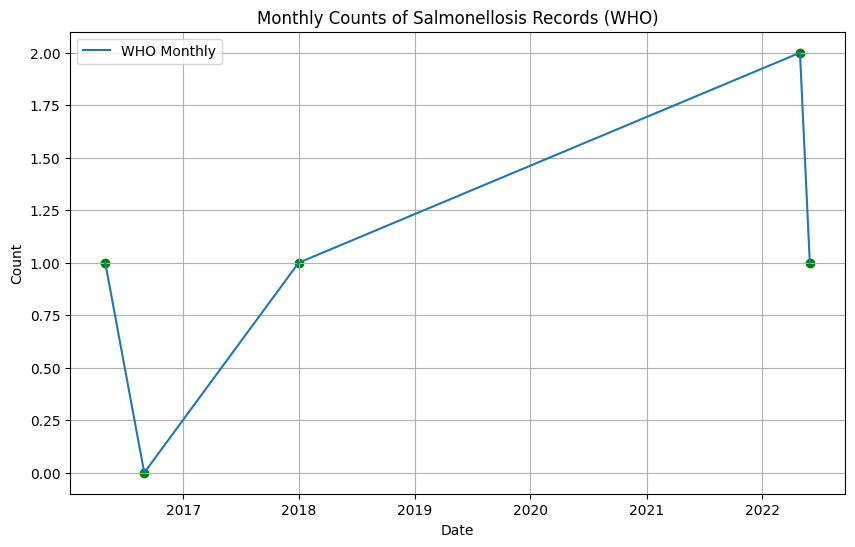

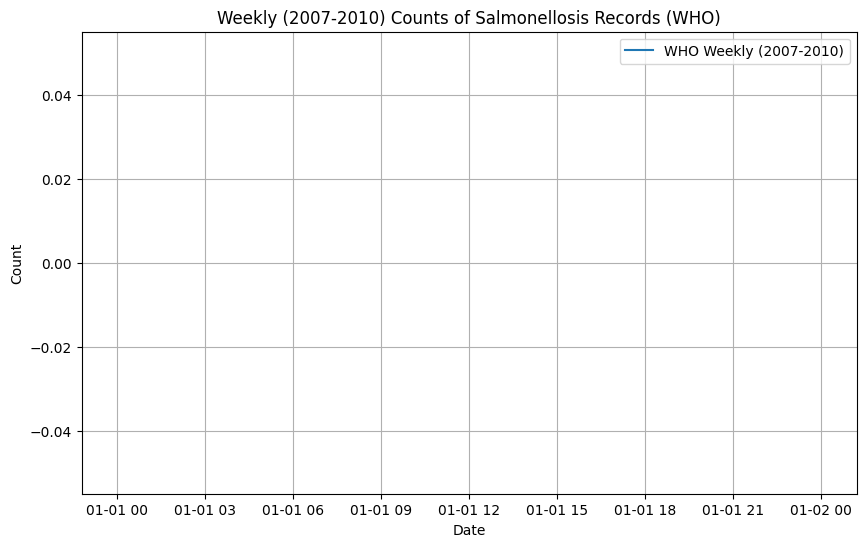

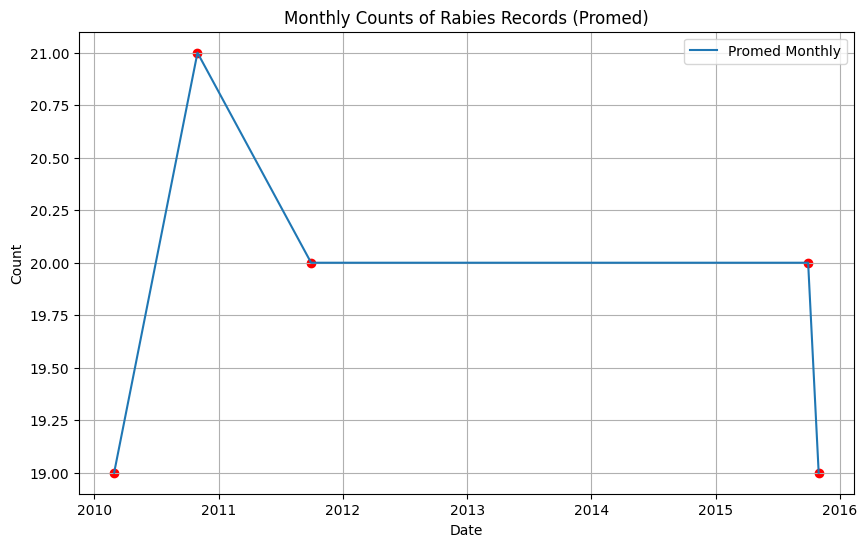

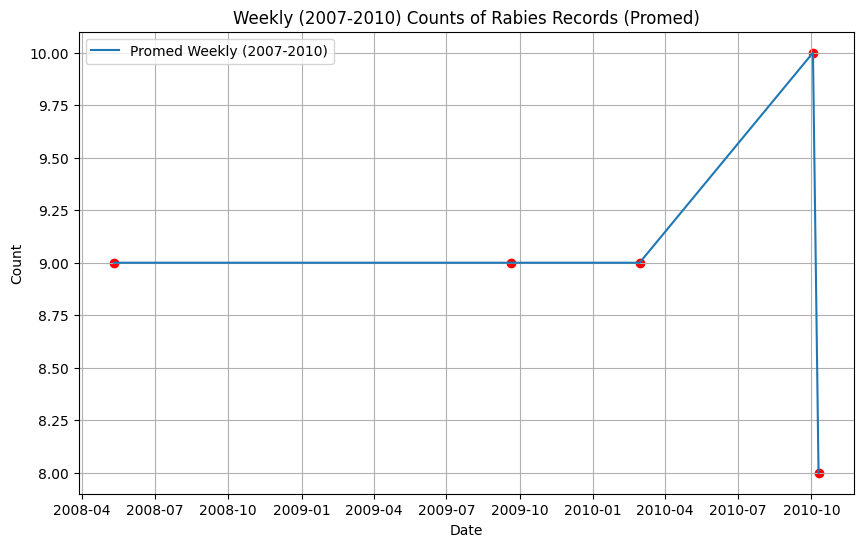

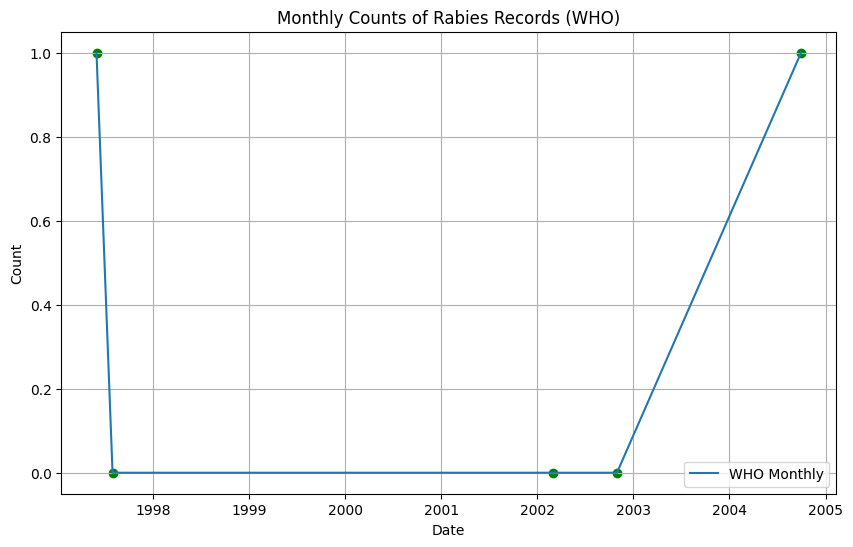

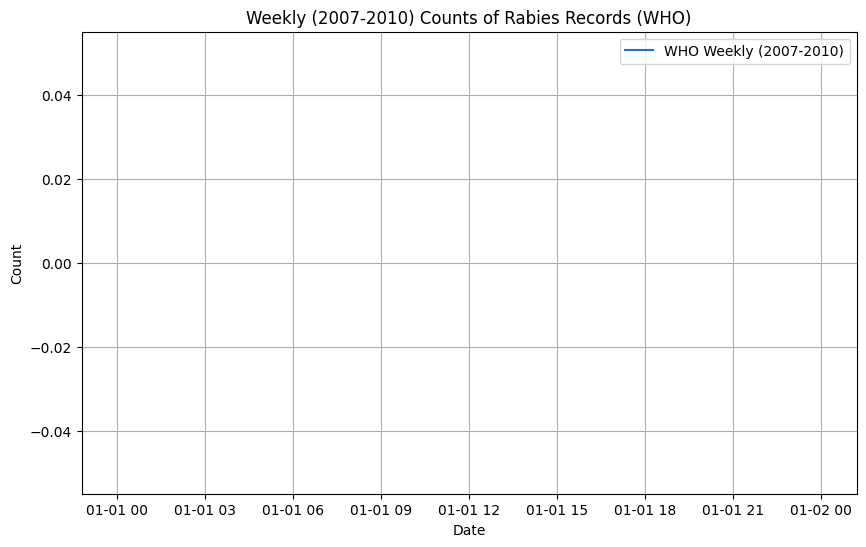

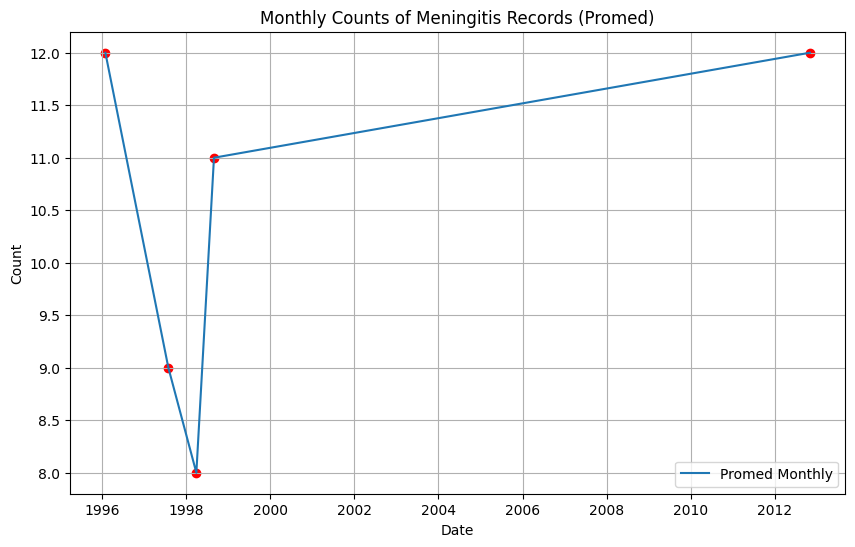

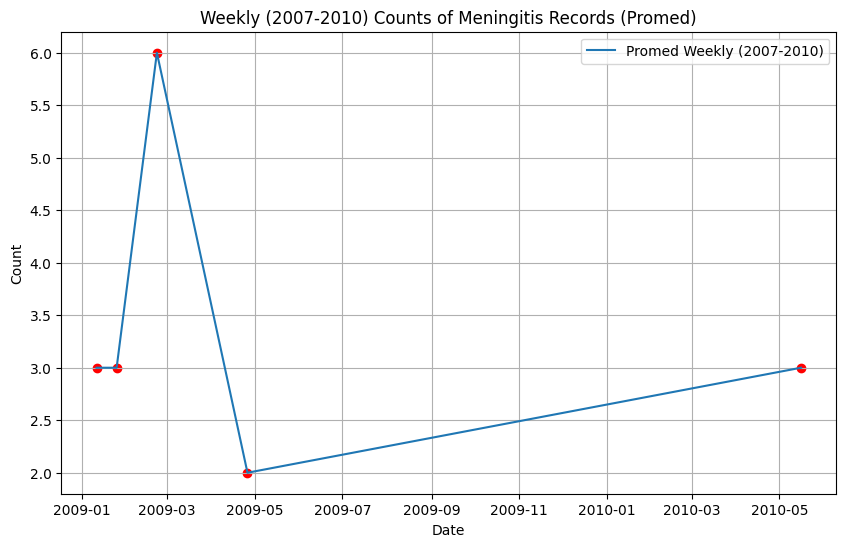

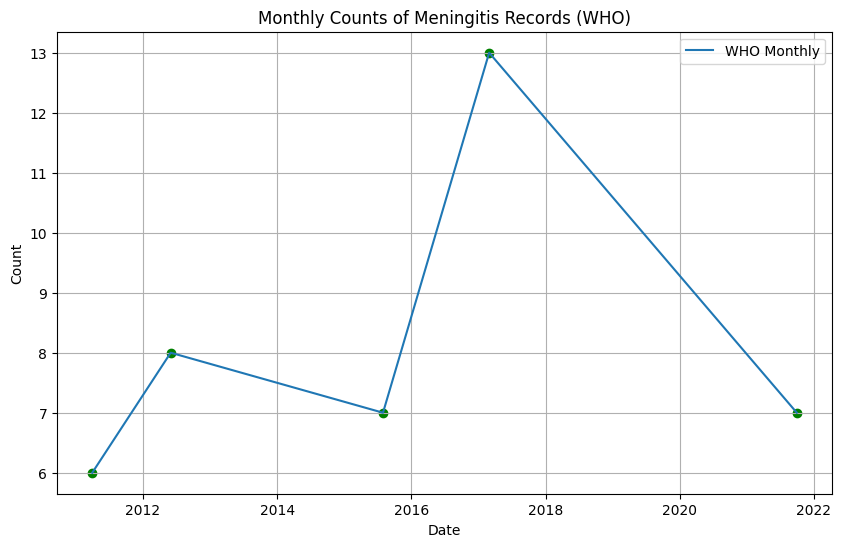

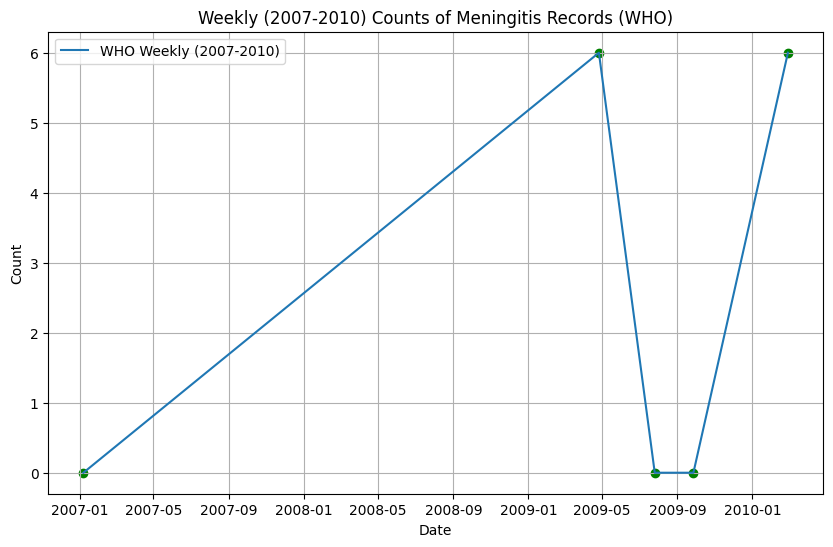

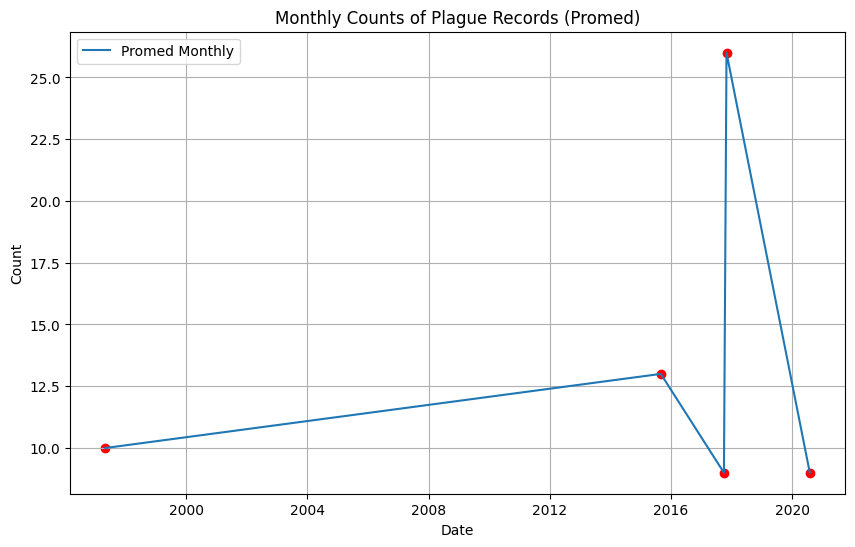

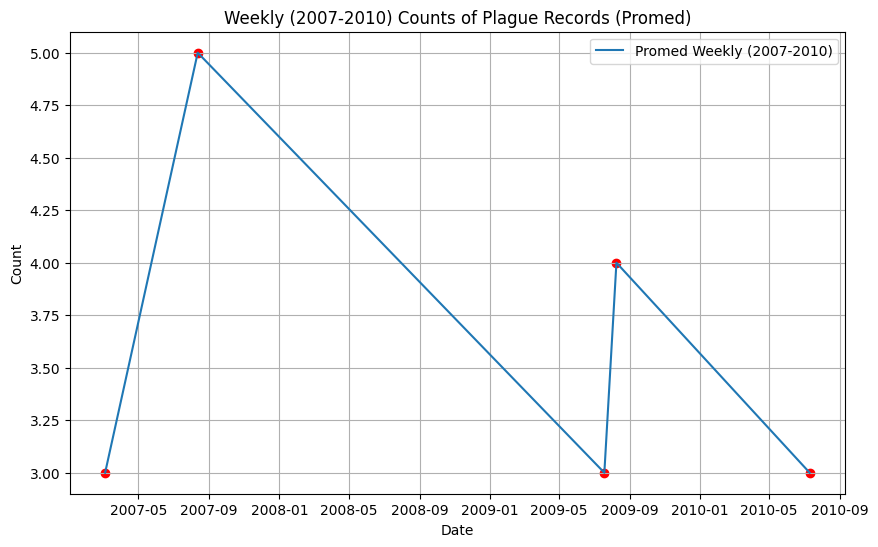

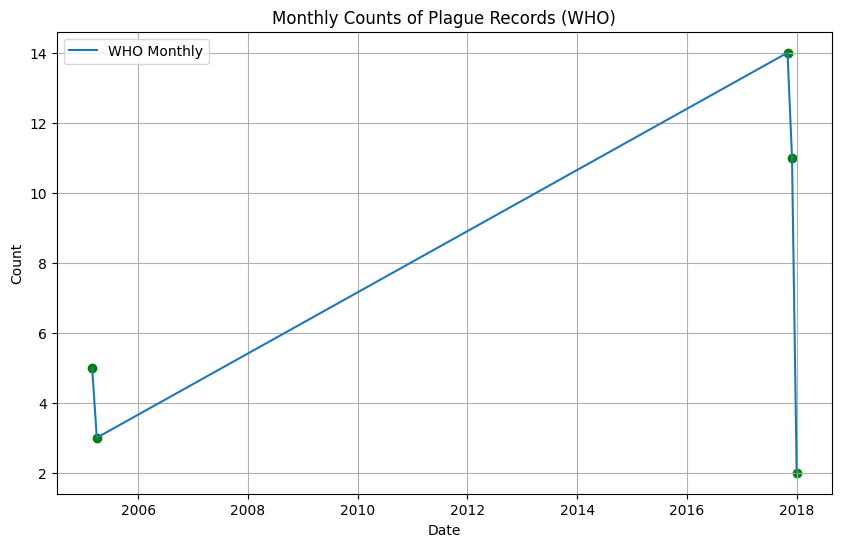

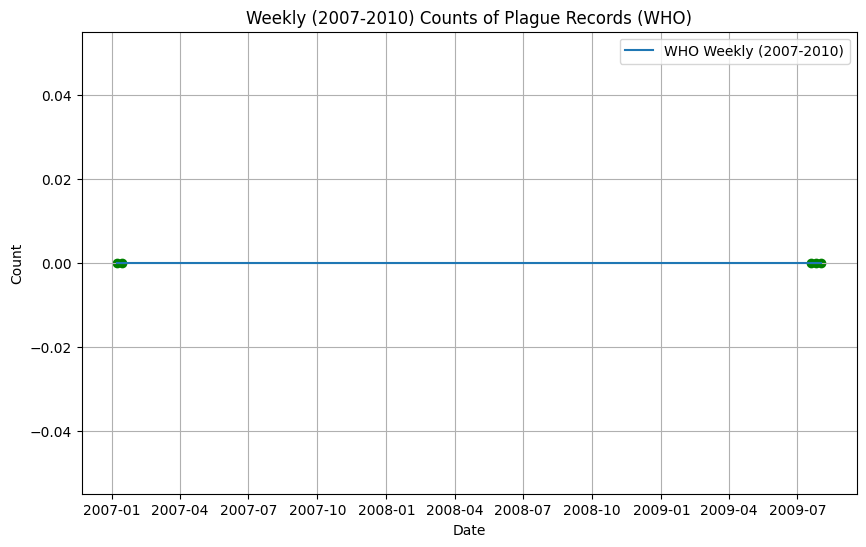

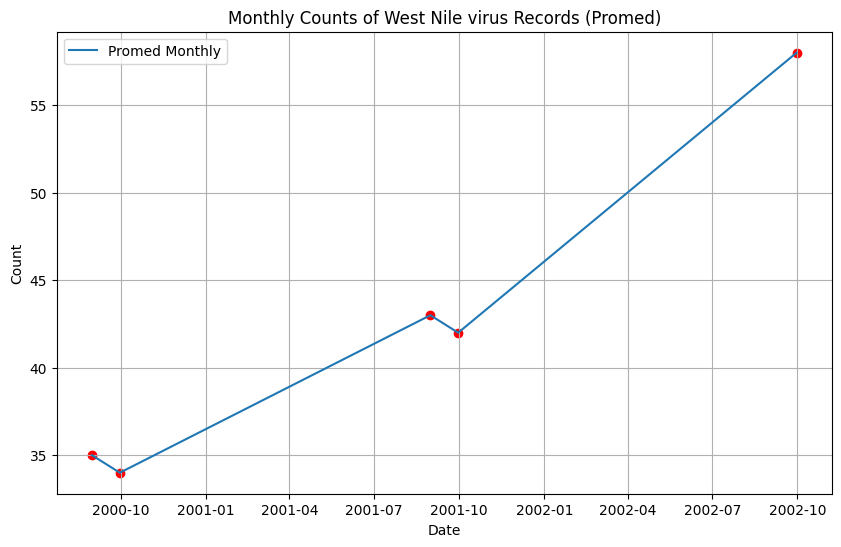

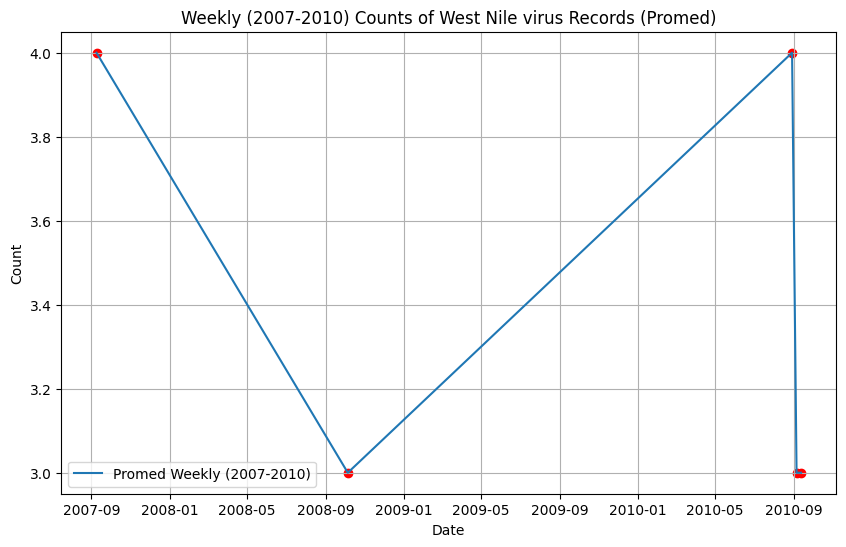

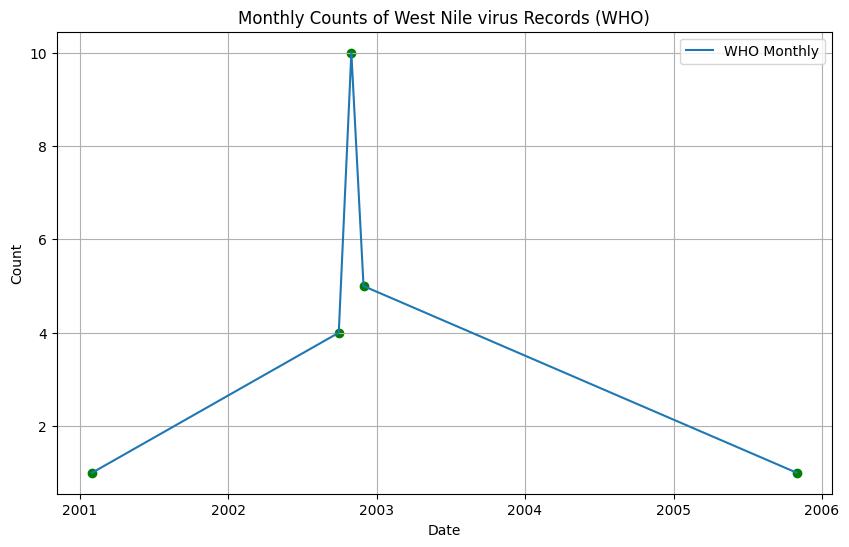

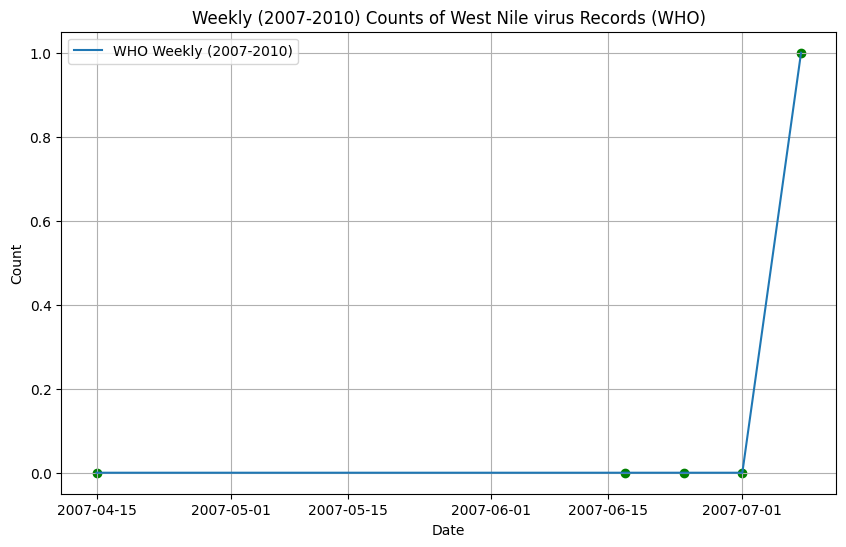

In [15]:
import matplotlib.pyplot as plt

def plot_peak_data_for_source(disease, source_label, data, frequency_label, color):
    """
    Plots the peak data for a given source and frequency.

    Args:
    disease (str): Name of the disease.
    source_label (str): Label for the data source (e.g., "Promed", "WHO").
    data (pd.DataFrame): DataFrame containing the peak data.
    frequency_label (str): Label for the frequency (e.g., "Monthly", "Weekly (2007-2010)").
    color (str): Color to use for the scatter plot.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(data['date'], data['count'], label=f'{source_label} {frequency_label}')
    plt.scatter(data['date'], data['count'], color=color)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title(f'{frequency_label} Counts of {disease} Records ({source_label})')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_peak_data(peak_data):
    """
    Plots the peak data for each disease, for both Promed and WHO.

    Args:
    peak_data (dict): Dictionary containing peak data for each disease.

    Returns:
    None
    """
    for disease, data in peak_data.items():
        if 'Promed' in data:
            if 'Monthly' in data['Promed']:
                plot_peak_data_for_source(disease, 'Promed', data['Promed']['Monthly'], 'Monthly', 'r')
            if 'Weekly (2007-2010)' in data['Promed']:
                plot_peak_data_for_source(disease, 'Promed', data['Promed']['Weekly (2007-2010)'], 'Weekly (2007-2010)', 'r')
        if 'WHO' in data:
            if 'Monthly' in data['WHO']:
                plot_peak_data_for_source(disease, 'WHO', data['WHO']['Monthly'], 'Monthly', 'g')
            if 'Weekly (2007-2010)' in data['WHO']:
                plot_peak_data_for_source(disease, 'WHO', data['WHO']['Weekly (2007-2010)'], 'Weekly (2007-2010)', 'g')
            
plot_peak_data(data_dict)


In [ ]:
# # Plot the data
# for disease, disease_df in data_dict.items():
#     top_monthly_peaks = peak_data[disease]['Promed']['Monthly']
#     top_weekly_peaks_filtered = peak_data[disease]['Promed']['Weekly (2007-2010)']

#     monthly_counts = disease_df.resample('M').count()[['id1']].rename(columns={'id1': 'count'})
#     weekly_counts_filtered = disease_df.resample('W').count()[['id1']].rename(columns={'id1': 'count'}).reset_index()
#     weekly_counts_filtered = weekly_counts_filtered[(weekly_counts_filtered['date'] >= '2007-01-01') & (weekly_counts_filtered['date'] <= '2010-12-31')]

#     plot_counts(monthly_counts.reset_index(), 'count', f'Monthly Counts of {disease} Records', top_monthly_peaks)
#     plot_counts(weekly_counts_filtered, 'count', f'Weekly Counts of {disease} Records (2007-2010)', top_weekly_peaks_filtered)

In [7]:
# # Initialize LangChain components
# processor = TextProcessor()
# analyzer = TimeSeriesAnalyzer()
# summarizer = Summarizer()
# source_analyzer = ExternalSourceAnalyzer()

# # Data Loading and Preprocessing
# # Load the data
# # promed_data = pd.read_csv('promed_data.csv')
# # who_data = pd.read_csv('who_data.csv')

# # Use LangChain to clean and extract information from the dataset
# promed_cleaned = processor.clean_and_extract(promed_data)
# who_cleaned = processor.clean_and_extract(who_data)

# # Further processing steps if needed
# # ...

# # Time Series Analysis
# for disease, data in disease_dfs.items():
#     # Use LangChain to detect peaks in the time series data
#     peaks_promed = analyzer.detect_peaks(promed_cleaned[disease])
#     peaks_who = analyzer.detect_peaks(who_cleaned[disease])
    
#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(data['date'], data['count'], label='Data')
#     plt.scatter(peaks_promed['date'], peaks_promed['count'], color='r', marker='o', label='Promed Peaks')
#     plt.scatter(peaks_who['date'], peaks_who['count'], color='g', marker='x', label='WHO Peaks')
#     plt.xlabel('Date')
#     plt.ylabel('Count')
#     plt.title(f'Counts and Peaks of {disease} Records')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Comparative Analysis
# # Use LangChain to compare Promed and WHO data
# discrepancies = analyzer.compare_data(promed_cleaned, who_cleaned)

# # Analyze discrepancies
# for disease, discrepancy in discrepancies.items():
#     print(f'Discrepancies for {disease}: {discrepancy}')

# # Visualization and Report Generation
# # Use LangChain to summarize the analysis
# summary = summarizer.summarize_analysis(peaks_promed, peaks_who, discrepancies)

# # Print the summary
# print(summary)

# # Enhanced Interpretation
# # Use LangChain to find related articles and provide context
# context_insights = source_analyzer.find_related_articles(peaks_promed)

# # Print context insights
# for insight in context_insights:
#     print(insight)


In [8]:
# l = ['Avian influenza', 'Cholera', 'Anthrax', 'Salmonellosis', 'Rabies', 'Meningitis', 'Plague', 'West Nile virus']

# # l.remove('Cholera')
# # Remove multiple items using list comprehension

# l = [item for item in l if item not in ['Cholera', 'Anthrax']]

# print(l)
# print(len(l))